In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD, SMF_LPGD, rank_r_projection, compute_accuracy_metrics
from SMF_torch import smf

/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF.py:132: SyntaxWarning: invalid escape sequence '\h'
  '''
/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF.py:180: SyntaxWarning: invalid escape sequence '\h'
  '''
/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF.py:249: SyntaxWarning: invalid escape sequence '\h'
  '''
/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF.py:1304: SyntaxWarning: invalid escape sequence '\h'
  '''
/Users/yee/Code/SMF_BCD/SMF/notebooks/../src/SMF.py:1625: SyntaxWarning: invalid escape sequence '\h'
  '''


# Microarray Cancer Data

## Read data

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("whitegrid")

#sys.path.append('../data')  # Go one level up and then into src

"""
data = pd.read_csv('../Data/Breast_GSE70947.csv')
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
print("X.shape=", X.shape)

"""

data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
y = data['type'].values
y = [1 if y[i] == 'tumoral' else 0 for i in range(len(y))]
X0 = data.drop(columns=['samples', 'type']).values
X = (X0 - np.mean(X0, axis = 0))/(100*np.std(X0, axis = 0)) # normalization
#X = 10*X0/np.linalg.norm(X0)
print("X.shape=", X.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = np.asarray([Y_train]), np.asarray([Y_test])
covariate_train, covariate_test = None, None

gene_list0 = data.keys()
gene_list = gene_list0[2:]

X.shape= (51, 54675)
[0 1]


## SMF-W

### Use Block Coordiante Descent to fit SMF-W

In [3]:
r = 2 # number of latent gene groups
xi = 0.1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100


U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_BCD_class = SMF_BCD(X=[X_train, Y_train],  # data, label
                            X_test=[X_test, Y_test], 
                            n_components=r,  
                            ini_loading=W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                            # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                            ini_code = H0,
                            xi=xi,  # weight on label reconstruction error
                            nonnegativity=[False,False,False]) # nonnegativity constraints on code H, dictionary W[0], reg params W[1]

results_dict = SMF_BCD_class.fit(iter=iteration, subsample_size=None,
                                    option = "filter",
                                    if_compute_recons_error=False, if_validate=False)

results_dict.update({'method': 'SMF-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[ 0.54741358  0.16837465 -0.67706059]]


100%|██████████| 100/100 [00:01<00:00, 81.48it/s]

!!! pred_type filter
--- Training --- [threshold, AUC] =  [np.float64(0.452), np.float64(1.0)]
!!! FINAL [threshold, AUC] =  [np.float64(0.636), np.float64(0.975)]


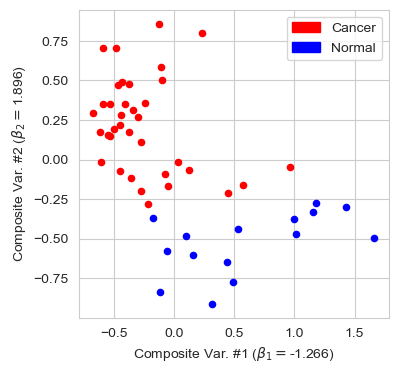

In [4]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot1", bbox_inches="tight", dpi=300)

In [5]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-3.54098331e-03  7.52916168e-03]
 [-2.65822883e-03  1.35029728e-03]
 [-2.83211066e-03  5.42245648e-03]
 ...
 [ 2.06958766e-03 -1.74150948e-05]
 [ 2.80718337e-03 -1.81101692e-04]
 [ 1.20638359e-03  2.36737688e-03]]
regression coefficients associated to the latent gene groups = [-1.26608607  1.89648295]
intercept term = 0.8400474860222391


### Use Low-rank Projected Gradient Descent to fit SMF-W

In [6]:
r = 2 # number of latent gene groups
xi = 1 # supervision parameter (weight for the matrix factorization loss)
iteration = 100

U0, S0, H0, recons = rank_r_projection(X_train, r)
W0 = U0 @ np.diag(S0) # initial filters = latent gene groups 
W0 = [W0, 1-2*np.random.rand(Y_train.shape[0], r + 1)] # initial filters + regression coefficients

SMF_LPGD_class = SMF_LPGD(X=[X_train, Y_train],  # data, label
                        X_test=[X_test, Y_test],
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        ini_loading = W0,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        ini_code = H0,
                        xi=xi)  # weight on label reconstruction error
                       

results_dict = SMF_LPGD_class.fit(iter=iteration, 
                                    beta = 0,
                                    nu = 0,
                                    stepsize=0.01,
                                    if_compute_recons_error=False, if_validate=False)

results_dict.update({'method': 'SDL-W'})
results_dict.update({'r': r})
results_dict.update({'xi': xi})
results_dict.update({'nu': None})

initial loading beta [[-0.78849373 -0.5602407  -0.19476697]]


100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [np.float64(0.636), np.float64(0.938)]
!!! ACC_list [np.float64(0.8461538461538461)]
--- Validation (filter) --- [threshold, AUC, accuracy, rel_error_data] = [0.630, 0.958, 0.846, 0.853]


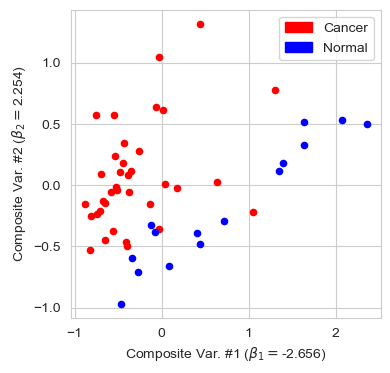

In [7]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=[4,4], constrained_layout=False)
outer_grid = gridspec.GridSpec(nrows=1, ncols=1, wspace=0, hspace=0)
inner_grid = outer_grid[0,0].subgridspec(1, 1, wspace=0, hspace=0)
ax = fig.add_subplot(inner_grid[0, 0])
colors = ["r", "b"]

W = results_dict.get("loading")[0]
Beta = results_dict.get("loading")[1]
X_comp = W.T @ X.T

for i in np.arange(len(y)):
    x1 = X_comp[0,i]
    x2 = X_comp[1,i]
    label = y[i]
    
    if label == 0:
        ax.scatter(x1, x2, s=20, c="b", alpha=1)
    else:
        ax.scatter(x1, x2, s=20, c="r", alpha=1)
        
red_patch = mpatches.Patch(color='red', label='Cancer')
blue_patch = mpatches.Patch(color='blue', label='Normal')
ax.legend(handles=[red_patch, blue_patch])

beta1 = np.round(Beta[0,1], 3)
beta2 = np.round(Beta[0,2], 3)
ax.set_xlabel(r"Composite Var. #1 ($\beta_{1}=$"+str(beta1) + ")")
ax.set_ylabel(r"Composite Var. #2 ($\beta_{2}=$"+str(beta2) + ")")



plt.savefig("plot2", bbox_inches="tight", dpi=300)

In [8]:
print("latent gene groups = " + "\n" + "{}".format(W))
print("regression coefficients associated to the latent gene groups = {}".format(Beta[0,1:]))
print("intercept term = {}".format(Beta[0,0]))

latent gene groups = 
[[-0.00183683  0.00445538]
 [-0.00393661  0.00049992]
 [-0.00316081  0.00529948]
 ...
 [ 0.00442916 -0.00081152]
 [ 0.00477214  0.00064371]
 [ 0.00338156  0.00242941]]
regression coefficients associated to the latent gene groups = [-2.65642341  2.25417124]
intercept term = 0.6212971929992069


### Use Pytorch implementation of BCD to fit SMF-W (utilizes GPU if possible)

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable

"""
#data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
data = pd.read_csv('../Data/Breast_GSE70947.csv')

print(data.shape)
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
y = np.array(y)
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
"""


hidden_size = 2

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()

smf_model = smf(X_train, y_train, hidden_size, device='cuda')
smf_model.fit(num_epochs=10000,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)
Accuracy.append(scmf_model.test(X_test, y_test))

TypeError: expected np.ndarray (got list)